# ADSP Big Data and Cloud Computing Final Project
## Part 3
## Author: Jingkai Wang
### Date: Dec 1, 2024

In [1]:
# import all libraries here
import os
import subprocess
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import explode, lower, count, year, expr, countDistinct, lit, size
from pyspark.sql.functions import col, from_unixtime, to_date, regexp_extract, when, array_union
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, MinHashLSH

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName('GCP Parquet') \
    .config('spark.sql.legacy.timeParserPolicy', 'LEGACY') \
    .config('spark.driver.memory', '8g') \
    .config('spark.driver.maxResultSize', '32g') \
    .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer') \
    .config('spark.kryoserializer.buffer.max', '1024m') \
    .config('spark.dynamicAllocation.enabled', 'true') \
    .getOrCreate()


spark.conf.set('spark.sql.repl.eagerEval.enabled',True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/02 09:16:24 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/12/02 09:16:24 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/12/02 09:16:25 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
24/12/02 09:16:25 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


## Load data into df

In [3]:
%%time
# define path
cleaned_data = 'gs://msca-bdp-students-bucket/notebooks/jingkaiw/cleaned_data'

# Read data   
df_languages = spark.read.parquet(os.path.join(cleaned_data, 'df_languages_cleaned'))
df_licenses = spark.read.parquet(os.path.join(cleaned_data, 'df_licenses_cleaned'))
df_commits = spark.read.parquet(os.path.join(cleaned_data, 'df_commits_cleaned'))
df_contents = spark.read.parquet(os.path.join(cleaned_data, 'df_contents_cleaned'))
df_files = spark.read.parquet(os.path.join(cleaned_data, 'df_files_cleaned'))


CPU times: user 13.5 ms, sys: 5.34 ms, total: 18.8 ms
Wall time: 11.2 s


### Step 7: Identify what technologies are most frequently associated with Data Science or AI projects
- Did these technologies change over time?

In [4]:
# Define related keywords
keywords = ['machine learning', 'ml', 'deep learning', 'data science', 
            'neural network', 'ai', 'artificial intelligence', 'supervised', 
            'unsupervised', 'transformer', 'nlp', 'data', 'ds', 'modeling']

# Filter commit messages for AI-related terms
df_commits_dsai = df_commits.filter(
    lower(col('message')).rlike('|'.join(keywords)) | lower(col('subject')).rlike('|'.join(keywords))
)

# Select the unique repos with keywords
df_repo_dsai = df_commits_dsai.select('repo_name').distinct()

# Join the df_languages
df_repo_lan_dsai = df_repo_dsai.join(df_languages, on='repo_name', how='inner')

# Aggregate related repository and languages
df_related = df_repo_lan_dsai.groupBy('language') \
                             .agg(count('repo_name').alias('repos_count')) \
                             .orderBy(F.desc('repos_count'))

# Show result
df_related.show(10)


+----------+-----------+
|  language|repos_count|
+----------+-----------+
|JavaScript|      22596|
|      HTML|      18635|
|       CSS|      18067|
|     Shell|      16927|
|    Python|      13822|
|      Ruby|       8613|
|      Java|       7646|
|  Makefile|       6992|
|         C|       6842|
|       PHP|       6603|
+----------+-----------+
only showing top 10 rows



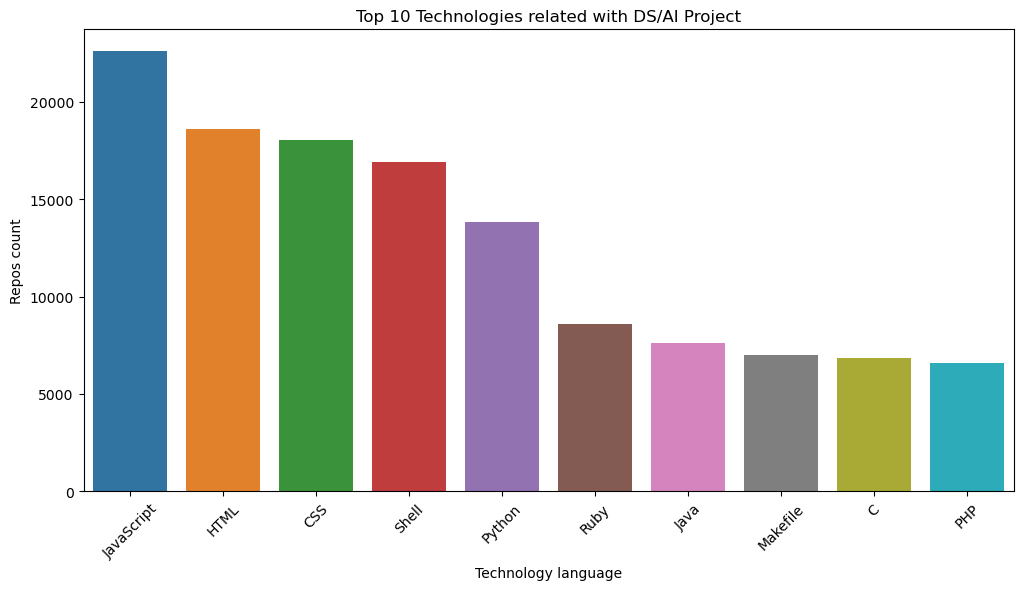

In [5]:
# convert to pandas
df_related_pd = df_related.toPandas()

# Plot the most related techs
plt.figure(figsize=(12, 6))
sns.barplot(x='language', y='repos_count', data=df_related_pd[:10])
plt.title('Top 10 Technologies related with DS/AI Project')
plt.xlabel('Technology language')
plt.ylabel('Repos count')
plt.xticks(rotation=45)
plt.show()

In [6]:
#  Extract year data
df_commits_dsai_year = df_commits_dsai.withColumn('year', year(col('author_date')))

# Join with df_languages
df_year = df_commits_dsai_year.join(df_languages, on='repo_name', how='inner')

# Group by data
df_year = df_year.groupBy('year', 'language') \
                 .agg(count('repo_name').alias('repo_count')) \
                 .orderBy('year', F.desc('repo_count'))

df_year.limit(10)

year,language,repo_count
1992,Mathematica,10
1992,Perl,10
1992,Go,10
1992,PostScript,10
1992,Modula-2,10
1992,Makefile,10
1992,Hack,10
1992,TeX,10
1992,Emacs Lisp,10
1992,Ada,10


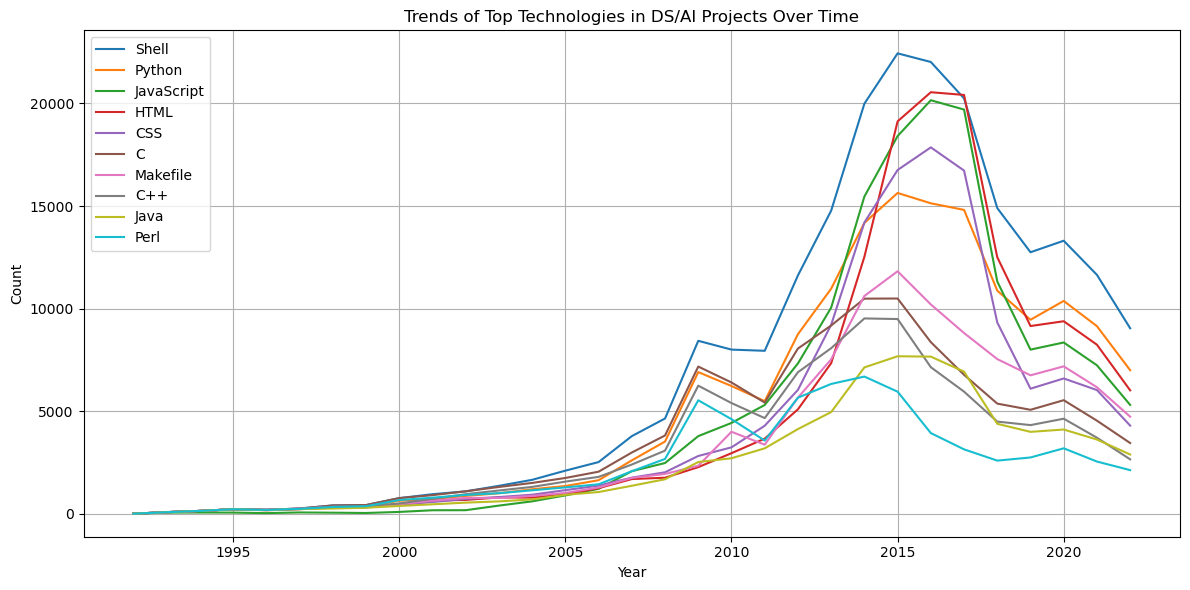

In [7]:
# Convert to Pandas
df_year_pd = df_year.toPandas()

# Filter for the top 10 languages
top_languages = df_year_pd.groupby('language')['repo_count'].sum().nlargest(10).index
df_trends = df_year_pd[df_year_pd['language'].isin(top_languages)]

# Plot trends over time
plt.figure(figsize=(12, 6))
for language in top_languages:
    language_data = df_trends[df_trends['language'] == language]
    plt.plot(language_data['year'], language_data['repo_count'], label=language)

plt.title('Trends of Top Technologies in DS/AI Projects Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**`JavaScript`, `HTML`, `CSS`. `Shell`, `Python` are the five most frequently associated with Data Science or AI projects. And `Shell` maintain consistant related with DS/AI Project. `HTML` became more related and reach the peak until 2016.**

### Step 8: What are the most frequent reasons for committing into GitHub repositories?
- Is this new technology development, bug fix, etc.

In [8]:
# Define keywords for each reasons
reasons = {
    'new_development': ['feature', 'add', 'new', 'create', 'implement', 'introduce'],
    'bug_fix': ['fix', 'bug', 'resolve', 'correct', 'issue'],
    'refactoring': ['refactor', 'clean', 'cleanup', 'rename', 'optimize', 'restructure'],
    'documentation': ['docs', 'doc', 'documentation', 'readme', 'comment'],
    'testing': ['test', 'unit test', 'integration', 'ci', 'testing'],
    'configuration': ['config', 'build', 'setup', 'configuration'],
    'merging': ['merge', 'pull request'],
    'security': ['security', 'secure']
}

# create columns for each reasons
for reason, words in reasons.items():
    df_commits = df_commits.withColumn(reason, 
                                       when(lower(col('message')).rlike('|'.join(words)), 1).otherwise(0))

from pyspark.sql.functions import sum as spark_sum
# Sum the counts
df_commits_reasons = df_commits.select(
    spark_sum(col('new_development')).alias('new_development'),
    spark_sum(col('bug_fix')).alias('bug_fix'),
    spark_sum(col('refactoring')).alias('refactoring'),
    spark_sum(col('documentation')).alias('documentation'),
    spark_sum(col('testing')).alias('testing'),
    spark_sum(col('configuration')).alias('configuration'),
    spark_sum(col('merging')).alias('merging'),
    spark_sum(col('security')).alias('security'),
)

# convert to pandas
df_commits_reasons_pd = df_commits_reasons.toPandas()

# Set column
df_commits_reasons_pd = df_commits_reasons_pd.melt(var_name='reasons', value_name='count') \
                                             .sort_values(by='count', ascending=False)

# show the data
df_commits_reasons_pd.head(10)


,reasons,count
0,new_development,6475175
1,bug_fix,5156235
4,testing,3166985
6,merging,2792472
3,documentation,1943976
5,configuration,1406854
2,refactoring,1107419
7,security,67912


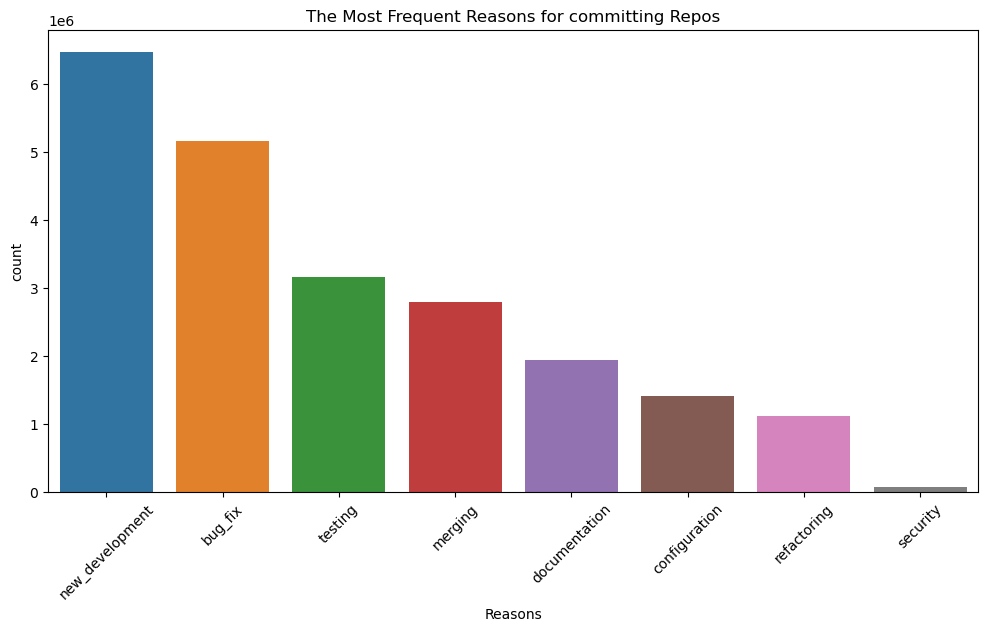

In [9]:
# Plot the most Frequent Reasons
plt.figure(figsize=(12, 6))
sns.barplot(x='reasons', y='count', data=df_commits_reasons_pd[:10])
plt.title('The Most Frequent Reasons for committing Repos')
plt.xlabel('Reasons')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

**`new_development`, `bug_fix`, and `testing` are the most frequent reasons for committing into GitHub repositories**

### Step 9: Identify the most prolific / influential Committers
- By commit volume 
- Visualize the distribution of these commits

In [10]:
# Aggregate commit volume by committer
df_volume = df_commits.groupBy('committer_name') \
                      .agg(count('commit').alias('commits_count')) \
                      .orderBy(F.desc('commits_count'))

# Show top 10 committers
df_volume.limit(10)


committer_name,commits_count
GitHub,2143411
Duane F. King,59822
Gerrit Code Review,59571
devs-mycroft,52518
Marge Spiderworthy,49332
Commit Bot,42134
Curt Clifton,38508
James Michael DuPont,34195
CI Pool Resource,31448
root,30430


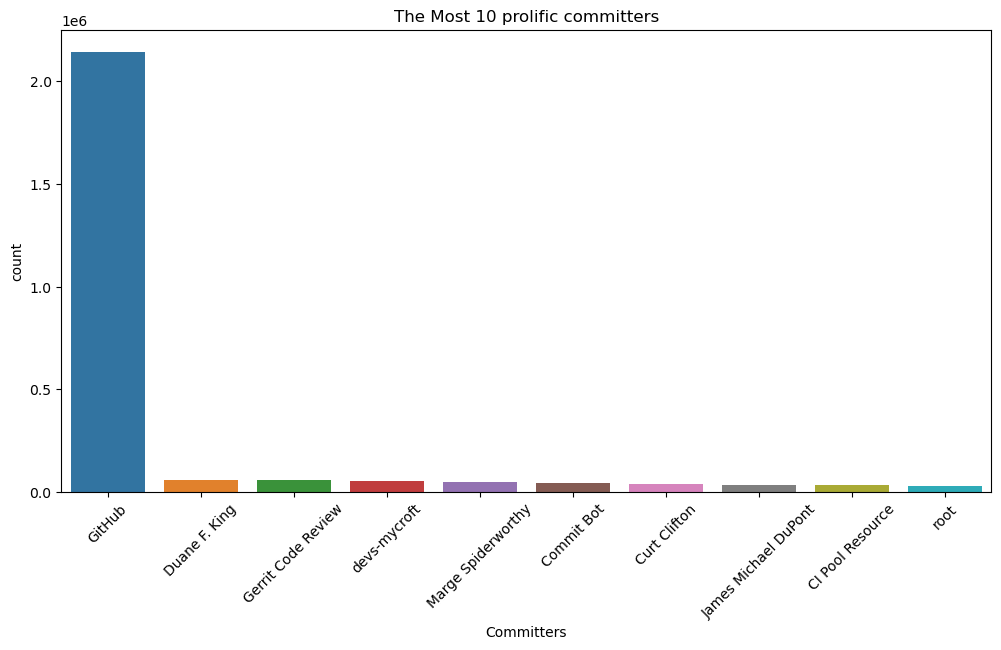

In [11]:
# Convert to pandas
df_volume_pd = df_volume.toPandas()

# Make the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='committer_name', y='commits_count', data=df_volume_pd[:10])
plt.title('The Most 10 prolific committers')
plt.xlabel('Committers')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

**`GitHub` is the most prolific / influential Committers**

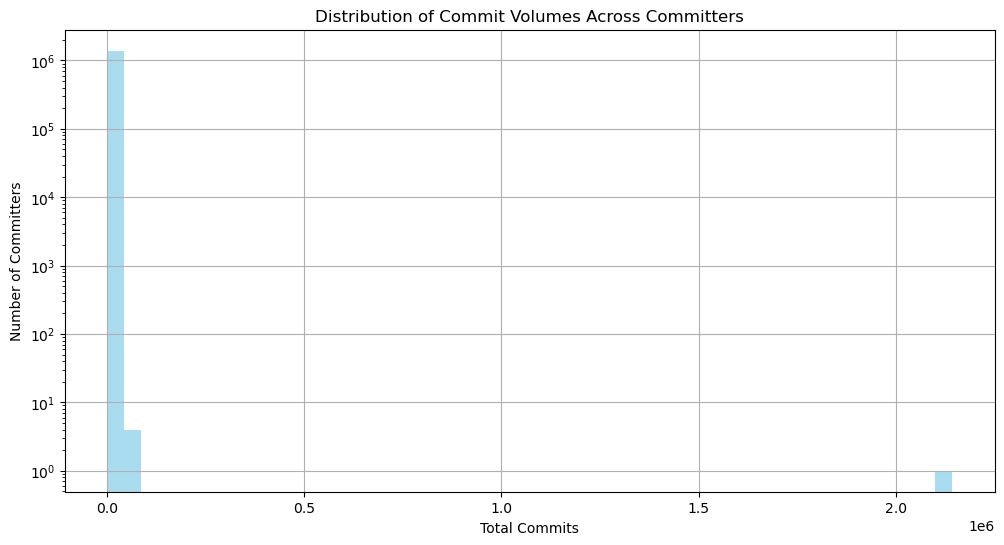

In [12]:
# Histogram to show distribution of commit volumes
plt.figure(figsize=(12, 6))
plt.hist(df_volume_pd['commits_count'], bins=50, color='skyblue', alpha=0.7, log=True)
plt.title('Distribution of Commit Volumes Across Committers')
plt.xlabel('Total Commits')
plt.ylabel('Number of Committers')
plt.grid()
plt.show()


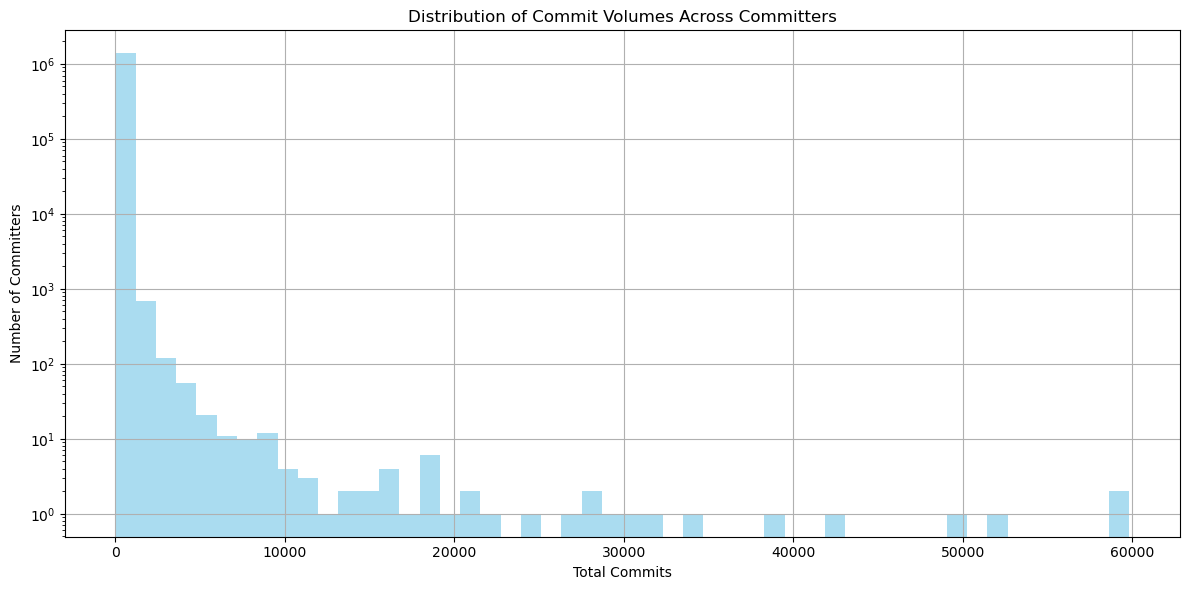

In [13]:
# Exclude "GitHub" from the data
df_volume_nogit = df_volume_pd[df_volume_pd['committer_name'] != 'GitHub']

# Plot the histogram for commit volumes
plt.figure(figsize=(12, 6))
plt.hist(df_volume_nogit['commits_count'], bins=50, color='skyblue', alpha=0.7, log=True)
plt.title('Distribution of Commit Volumes Across Committers')
plt.xlabel('Total Commits')
plt.ylabel('Number of Committers')
plt.grid()
plt.tight_layout()
plt.show()


### Step 10: How unique are the “subject” and “message” values?
- Are they mostly unique? Or are people usually just copy-pasting the same text?
- You can use LSH to measure uniqueness / similarity
- Visualize “subject” and “message” duplication across all programming languages
- Visualize “subject” and “message” duplication for each of the top 5 programming languages
- Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis

In [14]:
# make the data smaller since the cleaned data is still too large to analyze
fraction = 0.001
df_commits_small = df_commits.sample(withReplacement=False, fraction=fraction)

In [15]:
# seletc subject and message
df_select = df_commits_small.select('repo_name', 'subject', 'message')

# Tokenize the text in 'subject' and 'message'
tokenizer_sub = Tokenizer(inputCol='subject', outputCol='subject_tokens')
tokenizer_mes = Tokenizer(inputCol='message', outputCol='message_tokens')

# use tokensizer in df_select
df_select = tokenizer_sub.transform(df_select)
df_select = tokenizer_mes.transform(df_select)

# combine the tokenizer columns
df_select = df_select.withColumn('tokens', array_union(col('subject_tokens'), col('message_tokens')))

# Filter out rows where the combined_tokens column is empty
#df_select = df_select.filter(col('tokens').isNotNull())


# Convert tokens to feature vectors
hashing_tf = HashingTF(inputCol='tokens', outputCol='tokens_features')
df_select = hashing_tf.transform(df_select)

# Apply MinHashLSH 
mh = MinHashLSH(inputCol='tokens_features', outputCol='hashes', numHashTables=3)
lsh_model = mh.fit(df_select)
df_lsh = lsh_model.transform(df_select)

# Find similar texts and match teh contents
df_similar = lsh_model.approxSimilarityJoin(df_lsh, df_lsh, 0.8, distCol='JaccarDistance') \
                      .filter(col('datasetA.repo_name') == col('datasetB.repo_name')) \
                      .filter((col('datasetA.subject') != col('datasetB.subject')) |
                              (col('datasetA.message') != col('datasetB.message')))

# Count total and unique subjects
total = df_select.count()
duplicates = df_similar.count() // 2
unique = total - duplicates

print('Total text:', total)
print('Duplicate text:', duplicates)
print('Unique text:', unique)


Total text: 26164
Duplicate text: 1423
Unique text: 24741


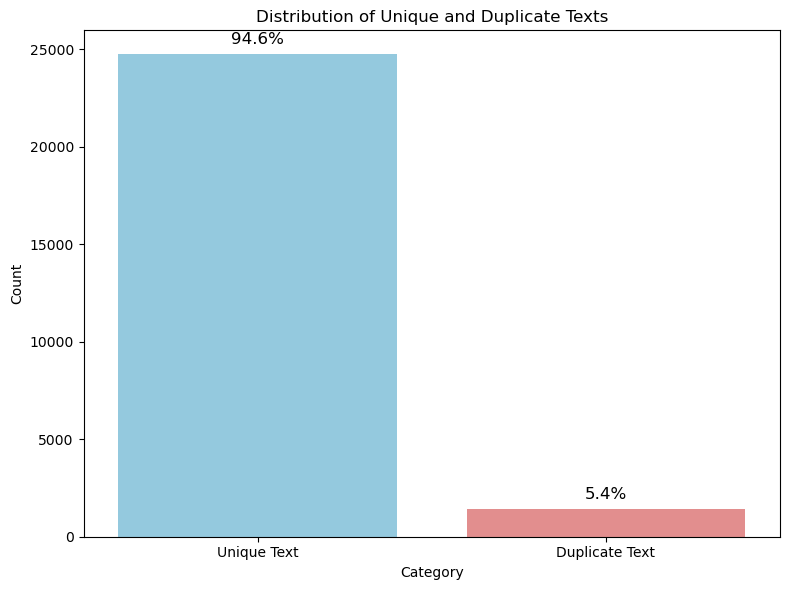

In [16]:
# Calculate percentages
unique_percentage = (unique / total) * 100
duplicate_percentage = (duplicates / total) * 100

# Data for the bar chart
data_dict = {'Category': ['Unique Text', 'Duplicate Text'], 
             'Count': [unique, duplicates], 
             'Percentage': [unique_percentage, duplicate_percentage]}
df = pd.DataFrame(data_dict)

# Create the bar chart
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(data=df, x='Category', y='Count', palette=['skyblue', 'lightcoral'])

# Add percentage annotations to each bar
for i, row in df.iterrows():
    bar_plot.text(i, row['Count'] + total * 0.02, f"{row['Percentage']:.1f}%", ha='center', fontsize=12)

plt.title('Distribution of Unique and Duplicate Texts')
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Yes, most of the `subject` and `message` are unique**

In [17]:
# Join df_lsh with df_languages
df_lsh_lan = df_lsh.join(df_languages, on='repo_name', how='inner')

# Join the df_similar
df_duplicates = df_similar.join(df_languages, df_similar.datasetA.repo_name == df_languages.repo_name, how='inner')

# group by the language with count
df_duplicates = df_duplicates.groupBy('language').count().orderBy(F.desc('count'))

# Display
df_duplicates.limit(10)

language,count
JavaScript,118
HTML,112
Shell,102
C,98
Perl,94
Python,94
Makefile,90
Roff,84
Lua,84
CSS,36


#### Visualize “subject” and “message” duplication across all programming languages

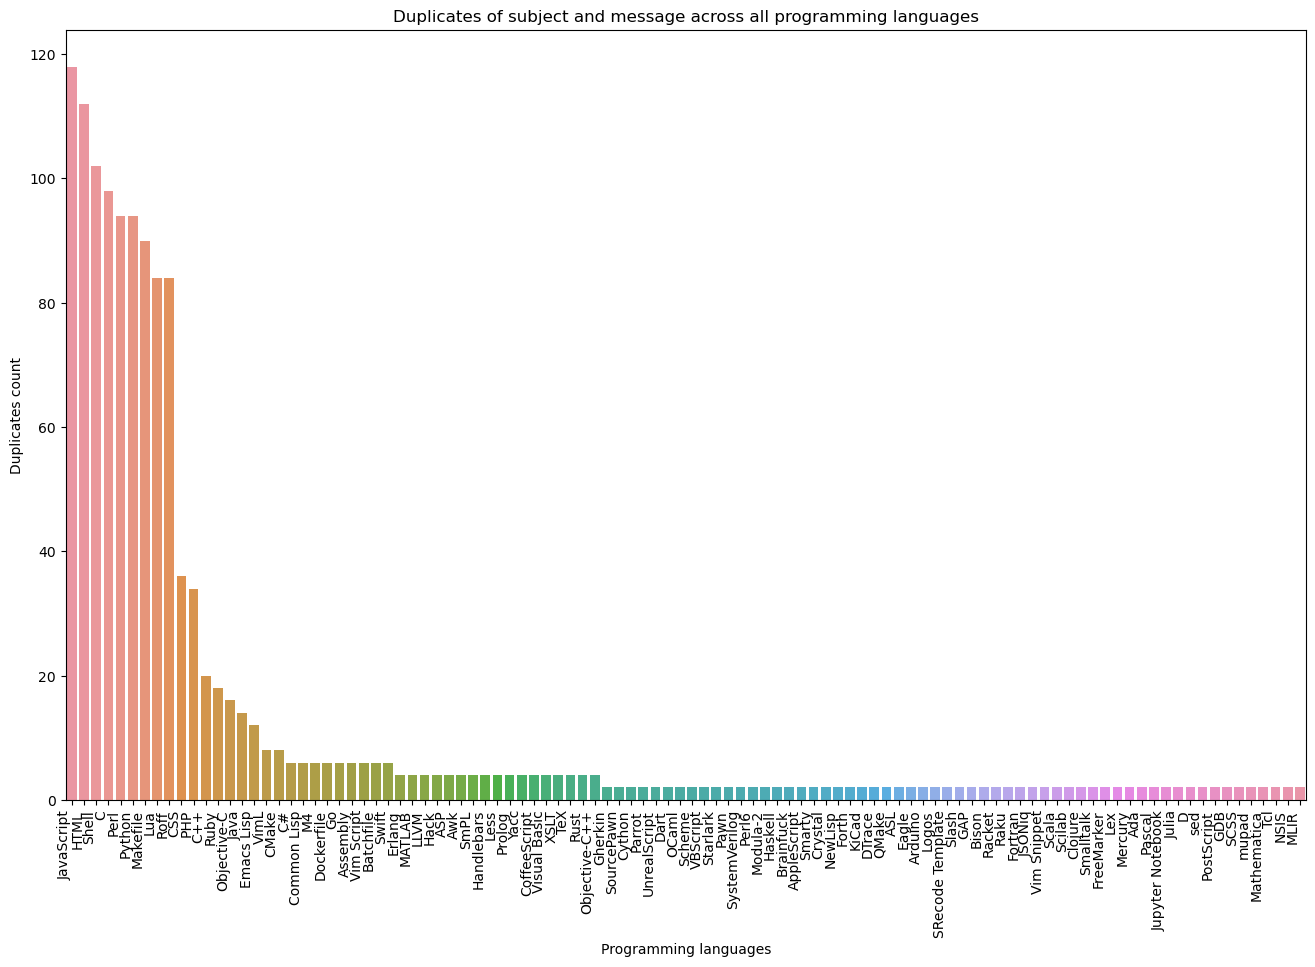

In [18]:
# Convert to pandas
df_duplicates_pd = df_duplicates.toPandas()

# Make the plot
plt.figure(figsize=(16, 10))
sns.barplot(x='language', y='count', data=df_duplicates_pd)
plt.title('Duplicates of subject and message across all programming languages')
plt.xlabel('Programming languages')
plt.ylabel('Duplicates count')
plt.xticks(rotation=90, ha='right')
plt.show()

#### Visualize “subject” and “message” duplication for each of the top 5 programming languages

In [19]:
# Extract top 5 language
top_5_lan = df_duplicates_pd.head(5)['language'].tolist()

# filter the duplication for top 5 languages
df_dup_5 = df_duplicates.filter(col('language').isin(top_5_lan))

# Display
df_dup_5

language,count
JavaScript,118
HTML,112
Shell,102
C,98
Perl,94


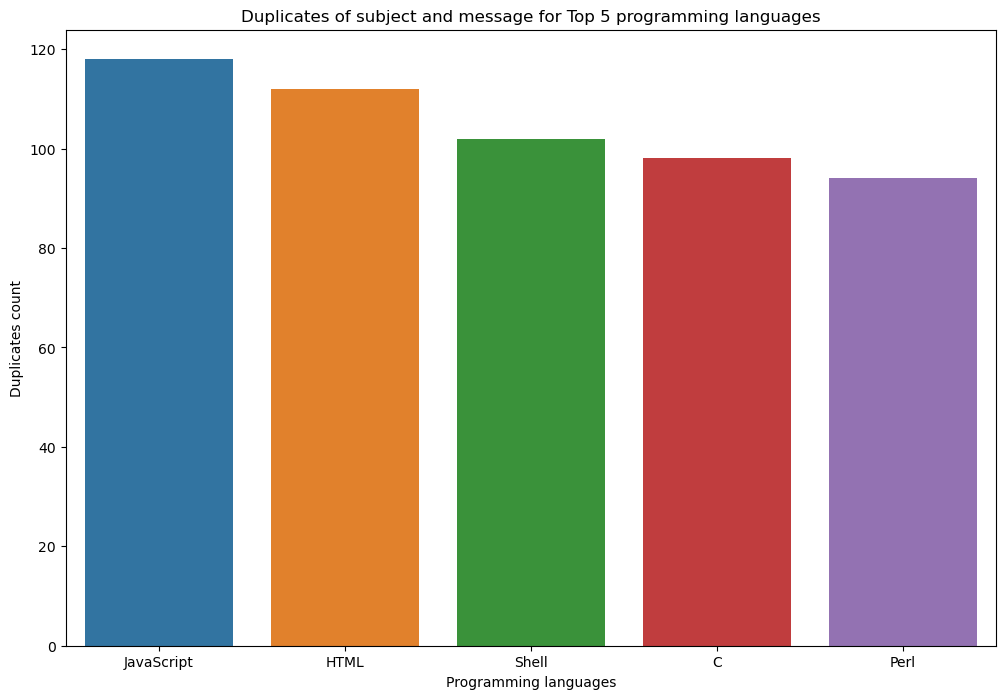

In [20]:
# convert to pandas
df_dup_5_pd = df_dup_5.toPandas()

# Make the plot
plt.figure(figsize=(12, 8))
sns.barplot(x='language', y='count', data=df_dup_5_pd)
plt.title('Duplicates of subject and message for Top 5 programming languages')
plt.xlabel('Programming languages')
plt.ylabel('Duplicates count')
plt.show()

In [21]:
# To check the most duplicate languages, the count is not enough since some languages count is less
# Count the languages
df_lan_count = df_lsh_lan.groupBy('language').count()
df_lan_count = df_lan_count.withColumnRenamed('count', 'language_count')

# calculate the percentage
df_dup_lan_pencent = df_duplicates.join(df_lan_count, 'language')
df_dup_lan_pencent = df_dup_lan_pencent.withColumn('percentage', (col('count') / col('language_count')) * 100)

# Select the languages and percentage only
df_dup_lan_pencent = df_dup_lan_pencent.select('language', 'percentage') \
                                       .orderBy(F.desc('percentage'))

# Display
df_dup_lan_pencent.limit(10)

language,percentage
mupad,66.66666666666666
Lua,61.31386861313869
Roff,57.534246575342465
JSONiq,50.0
Brainfuck,50.0
Crystal,40.0
Julia,40.0
Parrot,28.57142857142857
Vim Script,24.0
Perl,22.815533980582526


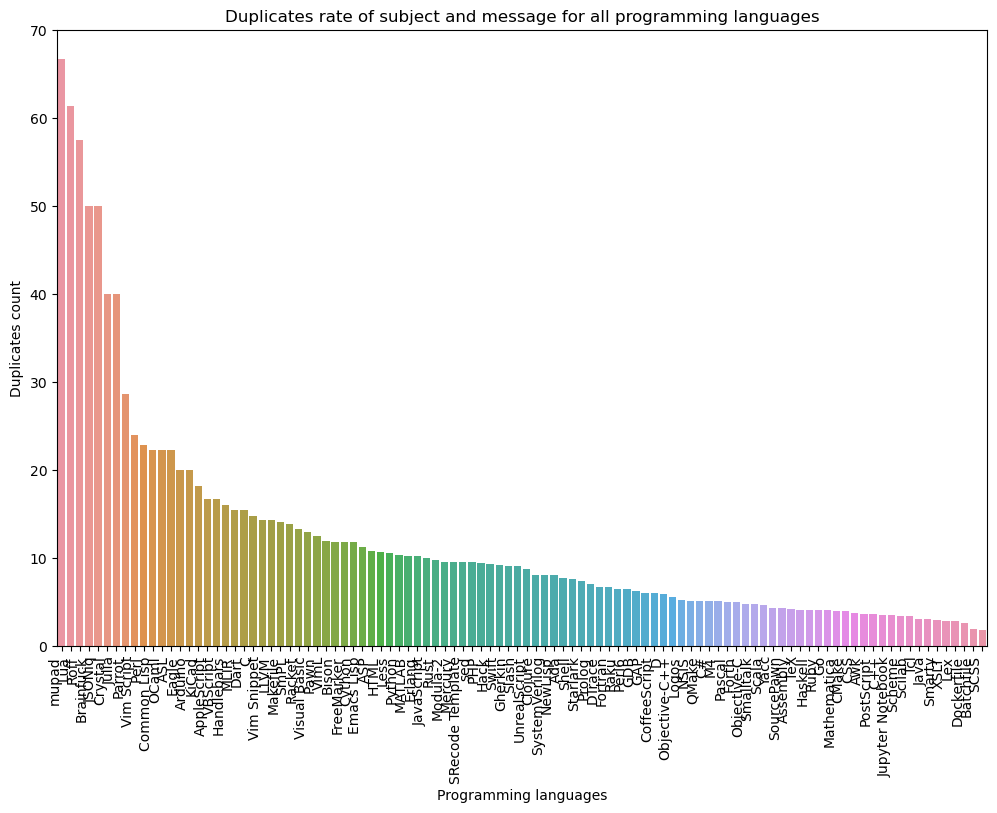

In [22]:
# convert to pandas
df_dup_lan_pencent_pd = df_dup_lan_pencent.toPandas()

# Make the plot
plt.figure(figsize=(12, 8))
sns.barplot(x='language', y='percentage', data=df_dup_lan_pencent_pd)
plt.title('Duplicates rate of subject and message for all programming languages')
plt.xlabel('Programming languages')
plt.ylabel('Duplicates count')
plt.xticks(rotation=90, ha='right')
plt.show()

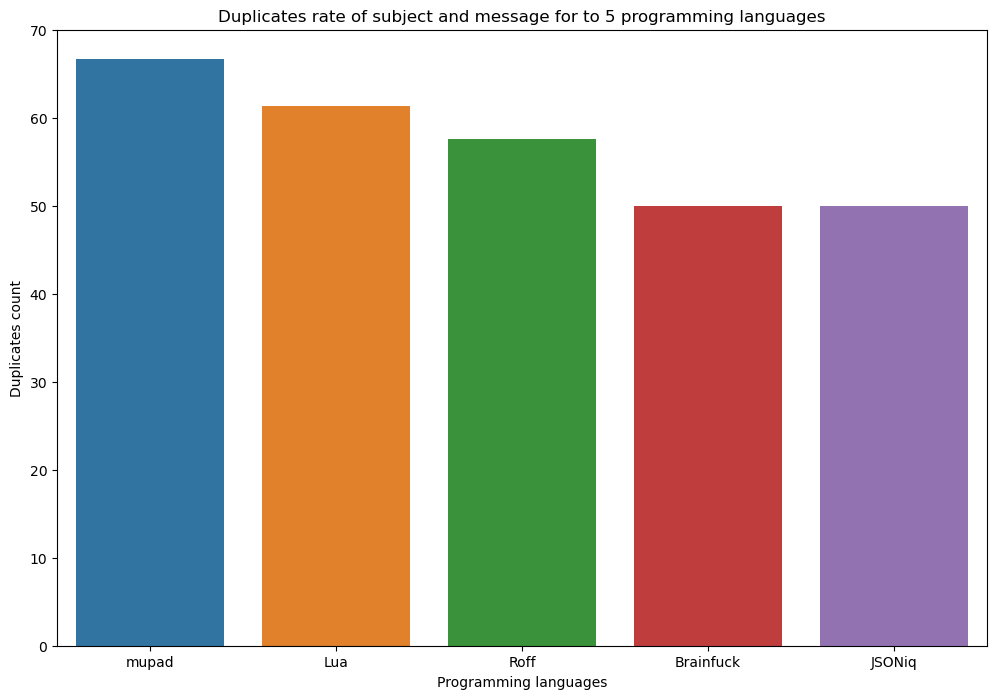

In [23]:
# Make the plot
plt.figure(figsize=(12, 8))
sns.barplot(x='language', y='percentage', data=df_dup_lan_pencent_pd[:5])
plt.title('Duplicates rate of subject and message for to 5 programming languages')
plt.xlabel('Programming languages')
plt.ylabel('Duplicates count')
plt.show()

In [24]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Mon, 02 December 2024 03:22:45'